In [1]:
# import rozneho potrebneho...

%load_ext autoreload
%autoreload

%matplotlib nbagg

import numpy as np
from scipy.integrate import odeint

import sys
sys.path.append('./misc/')

import plantFcns

# MRAC gradientný - SS1R - príklad

Nech riadený systém je daný prenosovou funkciou v tvare
\begin{equation}
    \frac{y(s)}{u(s)} = \frac{b_0}{s+a_0}
\end{equation}
Vo všeobecnosti sú parametre $a_0$ a $b_0$ neznáme, alebo sa menia v čase (tak, že je možné uplatniť adaptívne riadenie v rozsahu tohto kurzu). Pre potreby numerickej simulácie nech použijú sa hodnoty $a_0 = 0,55$ a $b_0 = 1,0$.

Nech zákon riadenia je v tvare
\begin{equation}
    u = \Theta_1 y + \Theta_2 r
\end{equation}

Navrhnime adaptívny riadiaci systém s využitím gradientného algoritmu adaptácie (MRAC --- gradientný). Pri tom nech referenčný model je v tvare
\begin{equation} \label{prtfrm}
    \frac{y_m(s)}{r(s)} = \frac{b_m}{s + a_m}
\end{equation}
kde $a_m = 1,0$ a $b_m = 1,0$.


V prvom rade, je vôbec možné, aby sa, v zmysle riadenia s referenčným modelom, zhodoval uzavretý regulačný obvod (URO) s referenčným modelom? Zostavme URO:
$$
    \begin{align}
        \frac{y}{r} &= \frac{b_0 \Theta_2}{\left( s + a_0 - b_0 \Theta_1 \right)} \label{prtfuro}
    \end{align}
$$



Je potrebné zistiť, kedy, a či vôbec, sa bude prenosová funkcia URO zhodovať s~referenčným modelom. Je očividné, že ak by boli parametre zákona riadenia $\Theta_1$ a $\Theta_2$ také, že
$$
    \begin{align}
        \Theta_1^\star &= \frac{-a_m + a_0}{b_0}  \\
        \Theta_2^\star &= \frac{b_m}{b_0}
    \end{align}
$$
potom URO a RM by sa zhodovali.


Navrhujeme adaptívny riadiaci systém s využitím gradientného prístupu, inými slovami, s využitím MIT pravidla. Pripomeňme, že zákon adaptácie má v tomto prípade vo všeobecnosti tvar
\begin{equation}
	\dot \Theta = - \alpha e \frac{\partial e}{\partial \Theta}
\end{equation}
V tomto prípade však máme dva parametre zákona riadenia a teda v tomto prípade je $\Theta$ vektorom, $\Theta^\mathsf T = \begin{bmatrix} \Theta_1 & \Theta_2 \end{bmatrix}$. Z toho vyplíva, že aj citlivostná funkcia $\frac{\partial e}{\partial \Theta}$ je má dva prvky (je vektorom). V každom prípade, pre nájdenie citlivostnej funckie (citlivostných funkcií) je potrebné vyjadriť adaptačnú odchýlku $e$ tak, aby obsahovala parametre zákona riadenia $\Theta$. Platí $e = y - y_m$. Ak sa za $y$ dosadí výraz, ktorý opisuje URO, potom
$$
    \begin{align}
        e &= y - y_m \\
        e &= b_0 \Theta_2 \, \left( s + a_0 - b_0 \Theta_1 \right)^{-1} r - y_m
    \end{align}
$$
Tento výraz potom možno derivovať podľa parametrov zákona riadenia $\Theta_1$ a $\Theta_2$.



$$
    \begin{align}
        \frac{\partial e}{\partial \Theta_1} &=  \frac{b_0}{\left( s + a_0 - b_0 \Theta_1 \right)}\, y
    \end{align}
$$
$$
    \begin{align}
        \frac{\partial e}{\partial \Theta_2} &=  \frac{b_0}{\left( s + a_0 - b_0 \Theta_1 \right)}\, r
    \end{align}
$$


Nájdené citlivostné fukcie nevieme realizovať, teda nevieme ich použiť v zákone adaptácie. Pretože obsahujú neznáme parametre riadeného systému, parametre $a_0$ a $b_0$. Aproximujme citlivostné funkcie. Ak $\alpha$ v zákone adaptácie je ľubovolné číslo, potom aj $\alpha\, b_0$ je ľubovolné číslo. Teda hodnotu $b_0$ stačí nahradiť len príslušným znamienkom (potrebujeme poznať znamienko parametra $b_0$). Ďalej, polynóm $\left( s + a_0 - b_0 \Theta_1 \right)$ je charakteristickým polynómom URO. To znamená, že ak by sa URO zhodoval s referenčným modelom, potom by pre tento charakteristický polynóm platilo $\left( s + a_0 - b_0 \Theta_1^\star \right)$. To ale znamená, že by sa zhodoval s charaketristickým polynómom referenčného modelu. Ak predpokladáme, že URO bude aspoň blízko referenčnému modelu počas celej doby, potom je charakteristický polynóm referenčného modelu vhodnou aproximáciou neznámeho polynómu v citlivostných funkciách. Z uvedeného plynie, že aproximácie citlivostných funkcií by mohli byť:
$$
    \begin{align}
        \frac{\partial e}{\partial \Theta_1} &\approx  \frac{1}{\left( s + a_m \right)}\, y \\
        \frac{\partial e}{\partial \Theta_2} &\approx  \frac{1}{\left( s + a_m \right)}\, r
    \end{align}
$$

S použitím týchto aproximácií citlivostných funkcií je teraz možné zostaviť zákony adaptácie podľa MIT pravidla, teda:
$$
    \begin{align}
        \dot \Theta_1 &= - \alpha e \left( \frac{1}{\left( s + a_m \right)}\, y \right) \\
        \dot \Theta_2 &= - \alpha e \left( \frac{1}{\left( s + a_m \right)}\, r \right)
    \end{align}
$$


Simulačnú schému nech realizuje nasledujúca funkcia:

In [2]:
def fcn_simSch2(t_start, T_s, finalIndex, sig_r_ext):

    #-----------------------------------------

    A_m = np.array([[-1]])
    b_m = np.array([[1]])

    A = np.array([[-0.55]])
    b = np.array([[1]])
    c = np.array([[1]])

    ThetaStar = np.array([[b_m[-1, 0]],[A_m[-1, 0] - A[-1, 0]]])

    #-----------------------------------------
    t_log = np.zeros([finalIndex, 1])
    t_log[0,:] = t_start

    #-----------------------------------------
    x_m_0 = np.array([0])

    x_m_log = np.zeros([finalIndex, len(x_m_0)])
    x_m_log[0,:] = x_m_0

    #-------------------------
    x_0 = np.array([0])

    x_log = np.zeros([finalIndex, len(x_0)])
    x_log[0,:] = x_0

    y_log = np.zeros([finalIndex, 1])
    y_log[0,:] = np.dot(c, x_0)


    #-------------------------
    u_log = np.zeros([finalIndex, 1])
    u_log[0,:] = 0

    xf1_log = np.zeros([finalIndex, 1])
    xf2_log = np.zeros([finalIndex, 1])


    Theta_log = np.zeros([finalIndex, 2])

    #-----------------------------------------
    timespan = np.zeros(2)
    for idx in range(1, int(finalIndex)):

        timespan[0] = t_log[idx-1,:]
        timespan[1] = t_log[idx-1,:] + T_s

        t_log[idx,:] = timespan[-1]

        # ------------
        # Referencny model realizovany pomocou riadneho ode solevera
        # Takyto ode solver nemusi byt vzdy dostupny z pohladu implemetnacie riadiaceho systemu

        odeOut = odeint(plantFcns.fcn_LTIS,
                        x_m_log[idx-1,:],
                        timespan,
                        args=(A_m, b_m, sig_r_ext[idx-1,:])
                        )

        x_m_log[idx,:] = odeOut[-1,:]

        # ------------

        odeOut = odeint(plantFcns.fcn_LTIS,
                        x_log[idx-1,:],
                        timespan,
                        args=(A, b, u_log[idx-1,:])
                        )

        x_log[idx,:] = odeOut[-1,:]
        y_log[idx,:] = np.dot(c, x_log[idx,:])

        # -------------------------

        alpha = 0.5

        omega = np.array([sig_r_ext[idx-1,:], y_log[idx-1,:]])
        adaptErr = y_log[idx-1, 0] - x_m_log[idx-1, 0]


        # Tu je numericka integracia realizovana jednoducho sumatorom - treba teda dbat na krok integrovania - teda tu to, co volame periodou vzorkovania
        dxf1 = np.matmul(A_m, xf1_log[idx-1,:]) + np.matmul(b_m, [omega[0,0]])
        xf1_log[idx,:] = xf1_log[idx-1,:] + dxf1 * T_s
        dTheta_1 = -alpha * adaptErr * xf1_log[idx-1,:]


        dxf2 = np.matmul(A_m, xf2_log[idx-1,:]) + np.matmul(b_m, [omega[1,0]])
        xf2_log[idx,:] = xf2_log[idx-1,:] + dxf2 * T_s
        dTheta_2 = -alpha * adaptErr * xf2_log[idx-1,:]

        Theta_log[idx,:] = np.array([
            Theta_log[idx-1, 0] + dTheta_1 * T_s,
            Theta_log[idx-1, 1] + dTheta_2 * T_s,
        ]).T


        u_log[idx,:] = np.dot(Theta_log[idx-1,:], omega)

        # ------------

        # ------------

    return [t_log, x_m_log, x_log, y_log, u_log, Theta_log]


In [3]:
# Nastavenia simulacie

sim_t_start = 0
sim_t_final = 100
sim_T_s = 0.005
sim_finalIndex = int(((sim_t_final - sim_t_start)/sim_T_s) + 1)


In [4]:
# Preddefinovane signaly

period_time = 20
period_tab = np.array([
                      [0, 1],
                      [10, -1],
                      ])

sig_vysl = np.zeros([sim_finalIndex, 1])

for period in range(int(sim_t_final/period_time) + 1):


    for idx in range( int((period*period_time)/sim_T_s), int((period*period_time + period_time)/sim_T_s)):

        lastValue = period_tab[:,1][(period_tab[:,0] + (period*period_time))<=idx*sim_T_s ][-1]
        try:
            sig_vysl[idx] = lastValue
        except:
            break

sig_r_ext = sig_vysl

In [5]:
# Spustenie simulacie

t_log, x_m_log, x_log, y_log, u_log, Theta_log = fcn_simSch2(
    sim_t_start,
    sim_T_s,
    sim_finalIndex,
    sig_r_ext,
    )

<IPython.core.display.Javascript object>


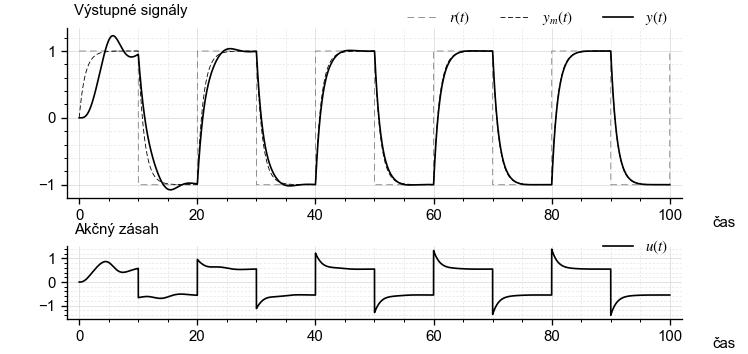

In [6]:
figNameNum = 2

exec(open('misc/fig_nb_01.py', encoding='utf-8').read())

<IPython.core.display.Javascript object>


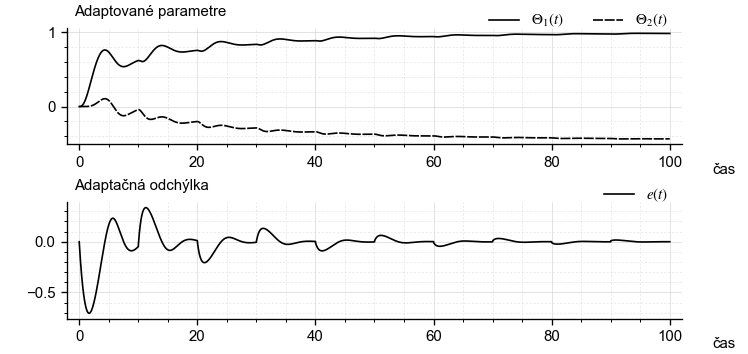

In [7]:
figNameNum = 3

exec(open('misc/fig_nb_02.py', encoding='utf-8').read())